# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import os
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import barplot,countplot
import matplotlib.pyplot as plt


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler,Normalizer,StandardScaler
from pyspark.ml.feature import MinMaxScaler #used because won't distort binary vars
from pyspark.sql.types import DoubleType,FloatType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Identify Features") \
    .getOrCreate()

df = spark.read.json('mini_sparkify_event_data.json')

# Print schema for future reference
df.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#clean dataset with empty userid
df = df.filter(df.userId != "")
print(f"Empty userIds: {df.filter(df.userId == '').count()}")

Empty userIds: 0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
# observation
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Look at first 5 rows for sample
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
# Amount of users 
df.select("userId").dropDuplicates().count()

225

In [8]:
# Amount of sessions
df.select("sessionId").dropDuplicates().count()

2312

In [9]:
churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())

df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))

In [10]:
#Distribution of user downgrades and cancellations
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled').describe().show()

+-------+------------------+------------------+------------------+
|summary|            userId|        downgraded|         cancelled|
+-------+------------------+------------------+------------------+
|  count|               225|               225|               225|
|   mean|65391.013333333336|              0.28|0.2311111111111111|
| stddev|105396.47791907164|0.5876709477736184|0.4224832108996327|
|    min|                10|                 0|                 0|
|    max|                99|                 3|                 1|
+-------+------------------+------------------+------------------+



In [11]:
windowvalue = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)


df = df.withColumn("churn_phase", Fsum("cancelled").over(windowvalue))\
    .withColumn("downgrade_phase", Fsum("downgraded").over(windowvalue))

In [12]:
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [13]:
song=udf(lambda x : int(x=='NextSong'), IntegerType())
home_visit=udf(lambda x : int(x=='Home'), IntegerType())
df = df.withColumn('date', get_day(col('ts')))

In [14]:
df.filter(col('churn_phase')==1).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()
df.filter(col('churn_phase')==0).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8112072039942939|
+------------------+

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8217840456084702|
+------------------+



In [15]:
days = lambda i: i * 86400 
daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [16]:
#number of songs played daily
df.filter((df.page=='NextSong')&(col('churn_phase')==1)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

df.filter((df.page=='NextSong')&(col('churn_phase')==0)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|              499|              499|
|   mean|77394.81563126252|72.93386773547094|
| stddev|90869.89716037885|71.24764235703725|
|    min|           100001|                1|
|    max|               87|              346|
+-------+-----------------+-----------------+

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|              2559|             2559|
|   mean| 64501.19812426729|74.91754591637358|
| stddev|114144.74005493976|74.02407951472078|
|    min|                10|                1|
|    max|                99|              360|
+-------+------------------+-----------------+



In [17]:
#number of songs couldn't be played due to errors
df.filter((df.page=='Error')&(df.churn_phase==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

df.filter((df.page=='Error')&(df.churn_phase==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

+-------+------------------+
|summary|       count(page)|
+-------+------------------+
|  count|                30|
|   mean|1.0666666666666667|
| stddev|0.2537081317024624|
|    min|                 1|
|    max|                 2|
+-------+------------------+

+-------+-------------------+
|summary|        count(page)|
+-------+-------------------+
|  count|                200|
|   mean|                1.1|
| stddev|0.31702131247412063|
|    min|                  1|
|    max|                  3|
+-------+-------------------+



In [18]:
#who cancelled subscriptions both free and paid
print(df.filter((df.page=='Cancellation Confirmation') & (df.level=='paid')).count(),
df.filter((df.page=='Cancellation Confirmation') & (df.level=='free')).count())

31 21


In [19]:
#number of users who downgraded
#number of users to cancel
print(df.filter(col('downgraded')==1).select('userId').dropDuplicates().count(), 
      df.filter(col('cancelled')==1).select('userId').dropDuplicates().count())

49 52


In [20]:
#users who downgraded and cancelled
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==1)&(col("cancelled")==1))\
    .count()

9

In [21]:
#number of times user opted for help
df.filter((df.page=='Help')&(df.churn_phase==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).describe().show()

df.filter((df.page=='Help')&(df.churn_phase==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).describe().show()

+-------+-----------------+------------------+
|summary|           userId|       count(page)|
+-------+-----------------+------------------+
|  count|              171|               171|
|   mean|62613.21052631579|1.3976608187134503|
| stddev| 88778.9002607509|0.8078987426633197|
|    min|           100001|                 1|
|    max|               87|                 6|
+-------+-----------------+------------------+

+-------+------------------+------------------+
|summary|            userId|       count(page)|
+-------+------------------+------------------+
|  count|               816|               816|
|   mean| 63176.38602941176|1.4889705882352942|
| stddev|115512.27837413888|0.8636495080491383|
|    min|                10|                 1|
|    max|                99|                 8|
+-------+------------------+------------------+



In [22]:
#number of users to cancel w/o downgrade
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==0)&(col("cancelled")==1))\
    .count()

43

In [23]:
#number of paid users to drop without downgrading -> big chunk of those
print(df.filter((col('cancelled')==1) & (col('downgraded')==0) & (col('level')=='paid'))\
      .select('userId').dropDuplicates().count())

31


In [24]:
#find those who done have diff listening habits?
df.filter(col('cancelled')==1).agg({'length':'mean'}).show()
df.filter(col('cancelled')==0).agg({'length':'mean'}).show()

+-----------+
|avg(length)|
+-----------+
|       null|
+-----------+

+-----------------+
|      avg(length)|
+-----------------+
|249.1171819778458|
+-----------------+



UsageError: Line magic function `%matplot` not found.


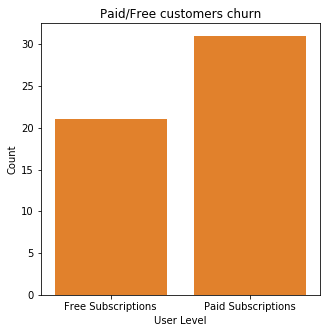

In [25]:
# Plotting a bar plot to show difference between Paid/Free customers churn
fig, ax = plt.subplots(figsize=(5, 5))

df_level_pd = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
plt.title('Paid/Free customers churn')
sns.barplot(data = df_level_pd, x = 'level', y = 'count', color = sns.color_palette()[1])

ax.set(xticklabels=['Free Subscriptions', 'Paid Subscriptions'])

ax.set_ylabel('Count')
ax.set_xlabel('User Level')
ax.legend()

%matplot plt

In [26]:
# Drop missing userId and sessionId
df = df.dropna(how = 'any', subset = ['userId','sessionId'])
df = df[df.userId != ""]

In [27]:
# add downgrade flag
df = df.withColumn('downgrade', when(df.page == 'Submit Downgrade', 1).otherwise(0))
df = df.withColumn('user_downgrade', Fmax('downgrade').over(Window.partitionBy('UserId')))

# add churn
df = df.withColumn('churn', when(df.page == 'Cancellation Confirmation', 1).otherwise(0))
df = df.withColumn('user_churn', Fmax('churn').over(Window.partitionBy('UserId')))


UsageError: Line magic function `%matplot` not found.


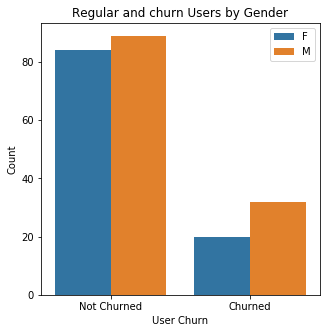

In [28]:
churn_gender_df = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().toPandas()
churn_gender_df



# Plotting a bar plot to show gender distribution between regular and churn users
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('Regular and churn Users by Gender')
ax = sns.barplot(x = 'user_churn', y = 'count', data = churn_gender_df, hue = 'gender')

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

%matplot plt

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:

# Marking the time and phase of churn for each user
# This will help us find metrics before and after churn for users


window = Window().partitionBy("userId").orderBy("ts").rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn_phase", Fsum("cancelled").over(window)).withColumn("downgrade_phase", Fsum("downgraded").over(window))

In [30]:
df.agg( Fmax(col("downgrade_phase")) ).show()

+--------------------+
|max(downgrade_phase)|
+--------------------+
|                   3|
+--------------------+



In [31]:
df.where(df.page == "NextSong").select(["userId", "level", "ts"]).groupby( [ "level", "userId" ] ).count().groupby("level").mean().show()

+-----+------------------+
|level|        avg(count)|
+-----+------------------+
| free|215.33846153846153|
| paid|1134.8597560975609|
+-----+------------------+



In [32]:
# Number of songs per session between paid and free

#Lets first compute average number of songs per session for each user

user_avg_songs_per_session = df.where(df.page == "NextSong") \
    .select(["userId", "level", "sessionId"]) \
    .groupby( [ "level", "userId", "sessionId" ] ).count() \
    .withColumnRenamed("count", "numSongsPerSession") \
    .groupby( [ "level", "userId" ] ).agg( { "numSongsPerSession" : "avg"}) \
    .withColumnRenamed("avg(numSongsPerSession)", "avgSongsPerSession")

# Now lets average across all users for free and paid respectively
user_avg_songs_per_session.groupby("level").mean() \
    .withColumnRenamed("avg(avgSongsPerSession)", "avgSongsPerSession") \
    .show()

+-----+------------------+
|level|avgSongsPerSession|
+-----+------------------+
| free| 31.28982093144803|
| paid|102.62525766710827|
+-----+------------------+



In [33]:
# Number of songs per day across free and paid

# We first convert the timestamp to date ( in UTC ) and add it to the dataframe

ts_date = udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000), DateType() )
df = df.withColumn("date", ts_date(col("ts")))

#Compute number of songs per day per user

user_avg_songs_per_day = df.where(df.page == "NextSong") \
    .select(["userId", "level", "date"]) \
    .groupby( [ "level", "userId", "date" ] ).count() \
    .withColumnRenamed("count", "numSongsPerDay") \
    .groupby( [ "level", "userId" ] ).agg( { "numSongsPerDay" : "avg"}) \
    .withColumnRenamed("avg(numSongsPerDay)", "avgSongsPerDay")

# Now lets average across all users for free and paid respectively
user_avg_songs_per_day.groupby("level").mean() \
    .withColumnRenamed("avg(avgSongsPerDay)", "avgSongsPerDay") \
    .show()

+-----+------------------+
|level|    avgSongsPerDay|
+-----+------------------+
| free|32.318292019819815|
| paid| 87.08996179115817|
+-----+------------------+



In [34]:
# Number of 404s per user

user_pagenotfound = df.filter(df.status == 404).select("userId", "status", "ts").groupby("userId").count().withColumnRenamed("count", "pagenotfound_instances")

user_pagenotfound.agg( Fmax(col("pagenotfound_instances")), Fmin(col("pagenotfound_instances"))  ).show()

+---------------------------+---------------------------+
|max(pagenotfound_instances)|min(pagenotfound_instances)|
+---------------------------+---------------------------+
|                          7|                          1|
+---------------------------+---------------------------+



In [35]:
# Number of errors per user

user_error_pages = df.filter(df.page == "Error").select("userId", "status", "ts").groupby("userId").count().withColumnRenamed("count", "error_instances")

user_error_pages.agg( Fmax(col("error_instances")), Fmin(col("error_instances"))  ).show()

+--------------------+--------------------+
|max(error_instances)|min(error_instances)|
+--------------------+--------------------+
|                   7|                   1|
+--------------------+--------------------+



In [36]:
# Thumbs up and thumbs down per user

user_thumbsup_perday = df.filter(df.page == "Thumbs Up") \
    .select("userId", "date") \
    .groupby( [ "userId", "date" ]) \
    .count() \
    .withColumnRenamed("count", "thumbsup") \
    .groupby("userId").mean() \
    .withColumnRenamed("avg(thumbsup)", "avg_thumbsup_per_day")
    
user_thumbsdown_perday = df.filter(df.page == "Thumbs Down") \
    .select("userId", "date") \
    .groupby( [ "userId", "date" ]) \
    .count() \
    .withColumnRenamed("count", "thumbsdown") \
    .groupby("userId").mean() \
    .withColumnRenamed("avg(thumbsdown)", "avg_thumbsdown_per_day")

In [37]:
# Number of help page visits

user_help_vists = df.filter(df.page == "Help").select("userId", "status", "ts").groupby("userId").count().withColumnRenamed("count", "help_visits")

user_help_vists.agg( Fmax(col("help_visits")), Fmin(col("help_visits"))  ).show()

+----------------+----------------+
|max(help_visits)|min(help_visits)|
+----------------+----------------+
|              46|               1|
+----------------+----------------+



In [38]:
# Number of friend referrals

user_num_friends = df.select(["userId", "page"]) \
    .filter(df.page == "Add Friend") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "numFriendAdditions")

In [39]:
# Abstract the data fetching from disk and basic cleanup into a function

def obtain_data(filepath):
    '''
    Given a file path:
    
    1. Read the events json file
    2. Remove records with null or empty string userId's and sessionId's
    '''
    df = spark.read.json(filepath=filepath)
    df = df.where( (df.userId.isNotNull()) & (df.sessionId.isNotNull()) & (df.userId != "") & (df.sessionId != "") )
    return df    

# Combine all the feature engineering and put in a single function

def feature_engineering(events_df):
    '''
    Given an events spark data frame, compute the necessary features for
    predicting churn using machine learning algorithms
    
    Inputs:
        events_df: Spark data frame with the structure        
         |-- artist: string (nullable = true)
         |-- auth: string (nullable = true)
         |-- firstName: string (nullable = true)
         |-- gender: string (nullable = true)
         |-- itemInSession: long (nullable = true)
         |-- lastName: string (nullable = true)
         |-- length: double (nullable = true)
         |-- level: string (nullable = true)
         |-- location: string (nullable = true)
         |-- method: string (nullable = true)
         |-- page: string (nullable = true)
         |-- registration: long (nullable = true)
         |-- sessionId: long (nullable = true)
         |-- song: string (nullable = true)
         |-- status: long (nullable = true)
         |-- ts: long (nullable = true)
         |-- userAgent: string (nullable = true)
         |-- userId: string (nullable = true)            
    
    Output:
        df_feature: Spark data frame with the following structure
        root
         |-- userId: string (nullable = true)
         |-- downgraded: integer (nullable = true)
         |-- cancelled: integer (nullable = true)
         |-- avgSongsPerSession: double (nullable = true)
         |-- avgSongsPerDay: double (nullable = true)
         |-- avg_thumbsup_per_day: double (nullable = true)
         |-- avg_thumbsup_per_day: double (nullable = true)
         |-- error_instances: long (nullable = false)
         |-- help_visits: long (nullable = false)
         |-- numFriendAdditions: long (nullable = false)
    '''
    
    churn = udf(lambda x: int(x == 'Cancellation Confirmation'), IntegerType())
    downgrade_churn = udf(lambda x: int(x == 'Submit Downgrade'), IntegerType())    
    signum = udf(lambda x: int(x>0), IntegerType())
    ts_date = udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000), DateType() )
    proportion = udf(lambda x,y : x/y, FloatType())
    
    ## Base transformations to input df
    events_df = events_df.withColumn("date", ts_date(col("ts")))       
       
    ## User level features    
    
    # Status of each user ( target variable )
    user_status = events_df.select(["userId", "downgraded", "cancelled"]) \
        .groupby("userId").sum() \
        .withColumnRenamed("sum(downgraded)" , "sum_downgraded") \
        .withColumnRenamed("sum(cancelled)" , "sum_cancelled") \

    user_status = user_status \
        .withColumn('downgraded', signum(col("sum_downgraded"))) \
        .withColumn('cancelled', signum(col("sum_cancelled"))) \
        .drop('sum_downgraded').drop('sum_cancelled')
    # The signum function is used since there are users who have multiple downgrade events.
        
    #Number of songs per session per user
    user_avg_songs_per_session = events_df.where(events_df.page == "NextSong") \
        .select(["userId", "sessionId"]) \
        .groupby( [ "userId", "sessionId" ] ).count() \
        .withColumnRenamed("count", "numSongsPerSession") \
        .groupby( [ "userId" ] ).agg( { "numSongsPerSession" : "avg"}) \
        .withColumnRenamed("avg(numSongsPerSession)", "avgSongsPerSession")
    
    #Number of songs per day per user
    user_avg_songs_per_day = events_df.where(events_df.page == "NextSong") \
        .select(["userId", "date"]) \
        .groupby( [ "userId", "date" ] ).count() \
        .withColumnRenamed("count", "numSongsPerDay") \
        .groupby( [ "userId" ] ).agg( { "numSongsPerDay" : "avg"}) \
        .withColumnRenamed("avg(numSongsPerDay)", "avgSongsPerDay")
    
    #Number of thumbs ups per day per user
    user_thumbsup_perday = events_df.filter(events_df.page == "Thumbs Up") \
        .select("userId", "date") \
        .groupby( [ "userId", "date" ]) \
        .count() \
        .withColumnRenamed("count", "thumbsup") \
        .groupby("userId").mean() \
        .withColumnRenamed("avg(thumbsup)", "avg_thumbsup_per_day")
    
    #Number of thumbs down per day per user
    user_thumbsdown_perday = events_df.filter(events_df.page == "Thumbs Down") \
        .select("userId", "date") \
        .groupby( [ "userId", "date" ]) \
        .count() \
        .withColumnRenamed("count", "thumbsdown") \
        .groupby("userId").mean() \
        .withColumnRenamed("avg(thumbsdown)", "avg_thumbsdown_per_day")    

    #Number of error pages encountered by user
    user_error_pages = events_df.filter(events_df.page == "Error") \
        .select("userId", "status", "ts") \
        .groupby("userId") \
        .count() \
        .withColumnRenamed("count", "error_instances")
    
    # Number of help page visits
    user_help_vists = events_df.filter(events_df.page == "Help") \
        .select("userId", "status", "ts") \
        .groupby("userId") \
        .count() \
        .withColumnRenamed("count", "help_visits")
    
    # Number of friend additions per user
    user_num_friends = events_df.select(["userId", "page"]) \
        .filter(df.page == "Add Friend") \
        .groupby("userId") \
        .count() \
        .withColumnRenamed("count", "numFriendAdditions")
    
    df_features = user_status \
        .join(user_avg_songs_per_session, on = "userId" , how = 'left') \
        .join(user_avg_songs_per_day, on = "userId", how = 'left') \
        .join(user_thumbsup_perday, on = "userId", how = 'left') \
        .join(user_thumbsdown_perday, on = "userId", how = 'left') \
        .join(user_error_pages, on = "userId", how = 'left') \
        .join(user_help_vists, on = "userId", how = 'left') \
        .join(user_num_friends, on = "userId", how = 'left')
    
    # Renaming the target column to label and casting it to DoubleType
    df_features = df_features.withColumn( "label", df_features.cancelled.cast(DoubleType())).drop("cancelled")
    
    return df_features

In [40]:
df_features = feature_engineering(df)
df_features.show(10)

+------+----------+------------------+------------------+--------------------+----------------------+---------------+-----------+------------------+-----+
|userId|downgraded|avgSongsPerSession|    avgSongsPerDay|avg_thumbsup_per_day|avg_thumbsdown_per_day|error_instances|help_visits|numFriendAdditions|label|
+------+----------+------------------+------------------+--------------------+----------------------+---------------+-----------+------------------+-----+
|100010|         0|39.285714285714285|39.285714285714285|  2.8333333333333335|                  1.25|           null|          2|                 4|  0.0|
|200002|         0|              64.5|55.285714285714285|                 3.0|                   3.0|           null|          2|                 4|  0.0|
|   125|         0|               8.0|               8.0|                null|                  null|           null|       null|              null|  1.0|
|   124|         0|145.67857142857142|         127.46875|   5.89655172

In [41]:
def feature_scaling(df_features):
    feature_cols = df_features.drop('userId', 'label').columns
    #Replace nulls with zero for columns in feature_cols
    df_features = df_features.fillna(0, subset = feature_cols )
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="FeatureVector")
    df_features = assembler.transform(df_features)
    
    scaler = StandardScaler(withMean = True, inputCol = "FeatureVector",  outputCol = "ScaledFeatureVector")
    scalerModel = scaler.fit(df_features)
    df_features = scalerModel.transform(df_features)
    df_features_scaled = df_features.select(["userId", "label", "ScaledFeatureVector"])    
    
    return df_features_scaled

In [42]:
df_features_scaled = feature_scaling(df_features)

In [43]:
df_features_scaled.persist()

DataFrame[userId: string, label: double, ScaledFeatureVector: vector]

In [44]:
df_features_scaled.show(10, False)

+------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|label|ScaledFeatureVector                                                                                                                                              |
+------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|100010|0.0  |[-0.5264710031632485,-0.7392637500378801,-0.783710508690406,-0.7321501459351433,-0.36390803366118396,-0.7605559300887401,-0.6161090451316099,-0.7292340618073143]|
|200002|0.0  |[-0.5264710031632485,-0.14759257929335814,-0.2848591481704853,-0.6465812558359041,1.8888671790512386,-0.7605559300887401,-0.6161090451316099,-0.7292340618073143]|
|125   |1.0  |[-0.5264710031632485,-1.473405316004171,-1.7591430797070366,-2.1868212776222102,-1.9730331855986287,-

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [45]:
train, validation = df_features_scaled.randomSplit([0.70, 0.30], seed = 42)
# test, validation = rest.randomSplit([0.50, 0.50], seed = 42)

In [46]:
def find_best_threshold_by_f1_score(preds, labelCol = 'label', probabilityCol = 'probability', steps = 1000):
    '''
        Given prediction probabilities by a classiification model, find the best threshold that maximizes fscore
        
        Input:
            preds - Spark dataframe with the following schema            
             |-- userId: string (nullable = true)
             |-- label: double (nullable = true)
             |-- ScaledFeatureVector: vector (nullable = true)
             |-- rawPrediction: vector (nullable = true)
             |-- probability: vector (nullable = true)
             |-- prediction: double (nullable = false)
        
        Output:
            best_threshold - Best threshold in [0,1] that maximizes fscore
            best_fscore - Best fscore achieved using the best_threshold
    '''
    labels = preds[labelCol]
    probability = preds[probabilityCol]
    fscores = []
    thresholds = np.linspace(0,1,steps)
    
    for thresh in thresholds:
        pred_labels = probability.apply(lambda x: np.float64(x > thresh))
        fscores.append( f1_score(labels, pred_labels) )
    
    return ( thresholds[ np.argmax(fscores) ], np.max(fscores) )

In [54]:
def evaluate_model(model, train, validation):
    '''
    Input:
        ML model after fitting
        
        Given a model we find the best threshold that gives the best f-score on the valdation data set
        Then we take this best threshold and apply that on the model predictions of the test data set.
        On this set set of predictions on the test set we compute precision, recall, f-score etc.
        
        We also compute area under the ROC curve for train, validation and test datasets
    
    Output:
        Metrics:
            AUC for train, validation and test            
            Best threshold based on validation
            FScore using best threshold on validation, test            
    '''
    
    model_preds_train = model.transform(train)
    model_preds_valid = model.transform(validation)
    
    evaluator_roc = BinaryClassificationEvaluator(metricName = 'areaUnderROC')
    auc_train = evaluator_roc.evaluate(model_preds_train)
    auc_valid = evaluator_roc.evaluate(model_preds_valid)
    
    model_preds_train_df = model_preds_train.select( [ 'userId', 'label', 'probability', 'prediction' ] ).toPandas()
    
    model_train_fscore = f1_score( model_preds_train_df.label, model_preds_train_df.prediction)
    model_train_precision = precision_score( model_preds_train_df.label, model_preds_train_df.prediction)
    model_train_recall = recall_score( model_preds_train_df.label, model_preds_train_df.prediction)
    model_train_accuracy = accuracy_score( model_preds_train_df.label, model_preds_train_df.prediction)
    
    model_preds_valid_df = model_preds_valid.select( [ 'userId', 'label', 'probability', 'prediction' ] ).toPandas()  
    
    model_valid_fscore = f1_score( model_preds_valid_df.label, model_preds_valid_df.prediction)
    model_valid_precision = precision_score( model_preds_valid_df.label, model_preds_valid_df.prediction)
    model_valid_recall = recall_score( model_preds_valid_df.label, model_preds_valid_df.prediction)
    model_valid_accuracy = accuracy_score( model_preds_valid_df.label, model_preds_valid_df.prediction)    
    
    metrics = {
        'train_auc' : auc_train,
        'valid_auc' : auc_valid,        
        'train_precision' : model_train_precision,
        'train_recall' : model_train_recall,
        'train_fscore' : model_train_fscore,
        'train_accuracy': model_train_accuracy,        
        'valid_precision' : model_valid_precision,
        'valid_recall' : model_valid_recall,
        'valid_fscore' : model_valid_fscore,
        'valid_accuracy': model_valid_accuracy
    }
    
    return metrics


In [47]:
%%time
# Random forest classifier
rf = RandomForestClassifier(
        featuresCol = "ScaledFeatureVector", 
        labelCol = 'label', 
        maxMemoryInMB = 1000, 
        seed = 42
    )
rf_model = rf.fit(train)

CPU times: user 224 ms, sys: 60.8 ms, total: 285 ms
Wall time: 49.8 s


In [55]:
rf_model.transform(train).printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: double (nullable = true)
 |-- ScaledFeatureVector: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [56]:
rf_model_metrics = evaluate_model(rf_model, train, validation)
rf_model_metrics

{'train_auc': 0.9857830271216097,
 'valid_auc': 0.6671195652173915,
 'train_precision': 1.0,
 'train_recall': 0.41666666666666669,
 'train_fscore': 0.58823529411764708,
 'train_accuracy': 0.87116564417177911,
 'valid_precision': 1.0,
 'valid_recall': 0.125,
 'valid_fscore': 0.22222222222222221,
 'valid_accuracy': 0.77419354838709675}

In [57]:
%%time
# Gradient boosted trees classifier
gbt = GBTClassifier(
        featuresCol = "ScaledFeatureVector", 
        labelCol = 'label', 
        maxMemoryInMB = 1000, 
        seed = 42,
    )
gbt_model = gbt.fit(train)


CPU times: user 3.77 s, sys: 1.01 s, total: 4.78 s
Wall time: 5min 32s


In [58]:
gbt_model_metrics = evaluate_model(gbt_model, train, validation)
gbt_model_metrics

{'train_auc': 0.9997812773403325,
 'valid_auc': 0.7472826086956519,
 'train_precision': 1.0,
 'train_recall': 0.97222222222222221,
 'train_fscore': 0.98591549295774639,
 'train_accuracy': 0.99386503067484666,
 'valid_precision': 0.59999999999999998,
 'valid_recall': 0.375,
 'valid_fscore': 0.46153846153846151,
 'valid_accuracy': 0.77419354838709675}

In [59]:
%%time

lr = LogisticRegression(featuresCol = "ScaledFeatureVector")
lr_model = lr.fit(train)


CPU times: user 715 ms, sys: 227 ms, total: 942 ms
Wall time: 49.5 s


In [60]:
lr_model_metrics = evaluate_model(lr_model, train, validation)
lr_model_metrics

{'train_auc': 0.8018372703412077,
 'valid_auc': 0.6480978260869564,
 'train_precision': 0.625,
 'train_recall': 0.27777777777777779,
 'train_fscore': 0.38461538461538458,
 'train_accuracy': 0.80368098159509205,
 'valid_precision': 0.5,
 'valid_recall': 0.125,
 'valid_fscore': 0.20000000000000001,
 'valid_accuracy': 0.74193548387096775}

In [62]:
%%time
# Random forest with cross validation
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5,10,20]) \
    .addGrid( rf.minInstancesPerNode, [5, 10, 20] ) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName = 'areaUnderROC'),
                          numFolds=3)
rf_cv_model = crossval.fit(train)

CPU times: user 8.23 s, sys: 2.24 s, total: 10.5 s
Wall time: 11min 7s


In [63]:
rf_cv_model_metrics = evaluate_model(rf_cv_model, train, validation)
rf_cv_model_metrics

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'train_auc': 0.6968503937007874,
 'valid_auc': 0.5353260869565217,
 'train_precision': 0.0,
 'train_recall': 0.0,
 'train_fscore': 0.0,
 'train_accuracy': 0.77914110429447858,
 'valid_precision': 0.0,
 'valid_recall': 0.0,
 'valid_fscore': 0.0,
 'valid_accuracy': 0.74193548387096775}

In [64]:
rf_cv_model.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_8afa81be378d', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_8afa81be378d', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_8afa81be378d', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_8afa81be378d', name='featuresCol', doc='features column name'): 'ScaledFeatureVector',
 Param(parent='RandomForestClassifier_8afa

In [69]:
%%time
# Gradient boosted trees with cross validation
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5,10]) \
    .addGrid(gbt.minInstancesPerNode, [5, 15] ) \
    .build()

gbt_crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName = 'areaUnderROC'),
                          numFolds=3)

gbt_cv_model = gbt_crossval.fit(train)


KeyboardInterrupt: 

In [70]:
gbt_cv_model_metrics = evaluate_model(gbt_cv_model, train, validation)

NameError: name 'gbt_cv_model' is not defined

In [ ]:
gbt_cv_model_metrics

In [ ]:
# Lets see what the best models parameters
gbt_cv_model.bestModel.extractParamMap()

In [ ]:

%%time
# Logistic regression with cross validation
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.05, 0.1] ) \
    .build()

lr_crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName = 'areaUnderROC'),
                          numFolds=3)

lr_cv_model = lr_crossval.fit(train)

In [ ]:
lr_cv_model_metrics = evaluate_model(lr_cv_model, train, validation)

In [ ]:
lr_cv_model_metrics


In [ ]:
#Comparing different models

all_metrics = pd.DataFrame( { 
    'Base RF': rf_model_metrics, 
    'CV RF' : rf_cv_model_metrics, 
    'Base GBT' : gbt_model_metrics, 
    'CV GBT' : gbt_cv_model_metrics,
    'Base LR' : lr_model_metrics,
    'CV LR' : lr_cv_model_metrics
}).sort_index()
all_metrics


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.